In [1]:
import numpy as np
import pandas as pd
import argparse
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
import pydotplus
from matplotlib import pyplot as plt
from labels import mac_to_label

In [ ]:
# extract argument
inputfile = "data.csv"
outputfile = "tree.tree"
#testfile = args.t

# output the tree
def get_lineage(tree, feature_names, file):
    proto = []
    src = []
    dst = []
    left = tree.tree_.children_left
    right = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features = [feature_names[i] for i in tree.tree_.feature]
    value = tree.tree_.value
    le = '<='
    g = '>'
    # get ids of child nodes
    idx = np.argwhere(left == -1)[:, 0]
    
    # traverse the tree and get the node information
    def recurse(left, right, child, lineage=None):
        if lineage is None:
            lineage = [child]
        if child in left:
            parent = np.where(left == child)[0].item()
            split = 'l'
        else:
            parent = np.where(right == child)[0].item()
            split = 'r'
        
        lineage.append((parent, split, threshold[parent], features[parent]))
        if parent == 0:
            lineage.reverse()
            return lineage
        else:
            return recurse(left, right, parent, lineage)

    for j, child in enumerate(idx):
        clause = ' when '
        for node in recurse(left, right, child):
                if len(str(node)) < 3:
                    continue
                i = node
                
                if i[1] == 'l':
                    sign = le
                else:
                    sign = g
                clause = clause + i[3] + sign + str(i[2]) + ' and '
    
    # wirte the node information into text file
        a = list(value[node][0])
        ind = a.index(max(a))
        clause = clause[:-4] + ' then ' + str(ind)
        file.write(clause)
        file.write(";\n")


In [7]:
# Training set X and Y
Set1 = pd.read_csv(inputfile)
Set = Set1.values.tolist()
X = [i[0:3] for i in Set]
Y =[i[3] for i in Set]

# Test set Xt and Yt
Set2 = pd.read_csv(inputfile)
Sett = Set2.values.tolist()
Xt = [i[0:3] for i in Set]
Yt =[i[3] for i in Set]

# prepare training and testing set
X = np.array(X)
Y = np.array(Y)
Xt = np.array(Xt)
Yt = np.array(Yt)

# decision tree fit
dt = DecisionTreeClassifier(max_depth = 5)
dt.fit(X, Y)
Predict_Y = dt.predict(X)
print(f"train accuracy: {accuracy_score(Y, Predict_Y)}")

Predict_Yt = dt.predict(Xt)
print(f"test accuracy: {accuracy_score(Yt, Predict_Yt)}")

train accuracy: 0.879490682862549
test accuracy: 0.879490682862549


In [12]:
class_names=list(mac_to_label.values())
feature_names=['proto','src','dst']

# output the tree in a text file, write it
threshold = dt.tree_.threshold
features  = [feature_names[i] for i in dt.tree_.feature]
proto = []
src = []
dst = []
for i, fe in enumerate(features):
    
    if fe == 'proto':
        proto.append(threshold[i])
    elif fe == 'src':
        if threshold[i] != -2.0:
            src.append(threshold[i])
    else:
        dst.append(threshold[i])
proto = [int(i) for i in proto]
src = [int(i) for i in src]
dst = [int(i) for i in dst]
proto.sort()
src.sort()
dst.sort()
tree = open(outputfile,"w+")
tree.write("proto = ")
tree.write(str(proto))
tree.write(";\n")
tree.write("src = ")
tree.write(str(src))
tree.write(";\n")
tree.write("dst = ")
tree.write(str(dst))
tree.write(";\n")
get_lineage(dt,feature_names,tree)
tree.close()

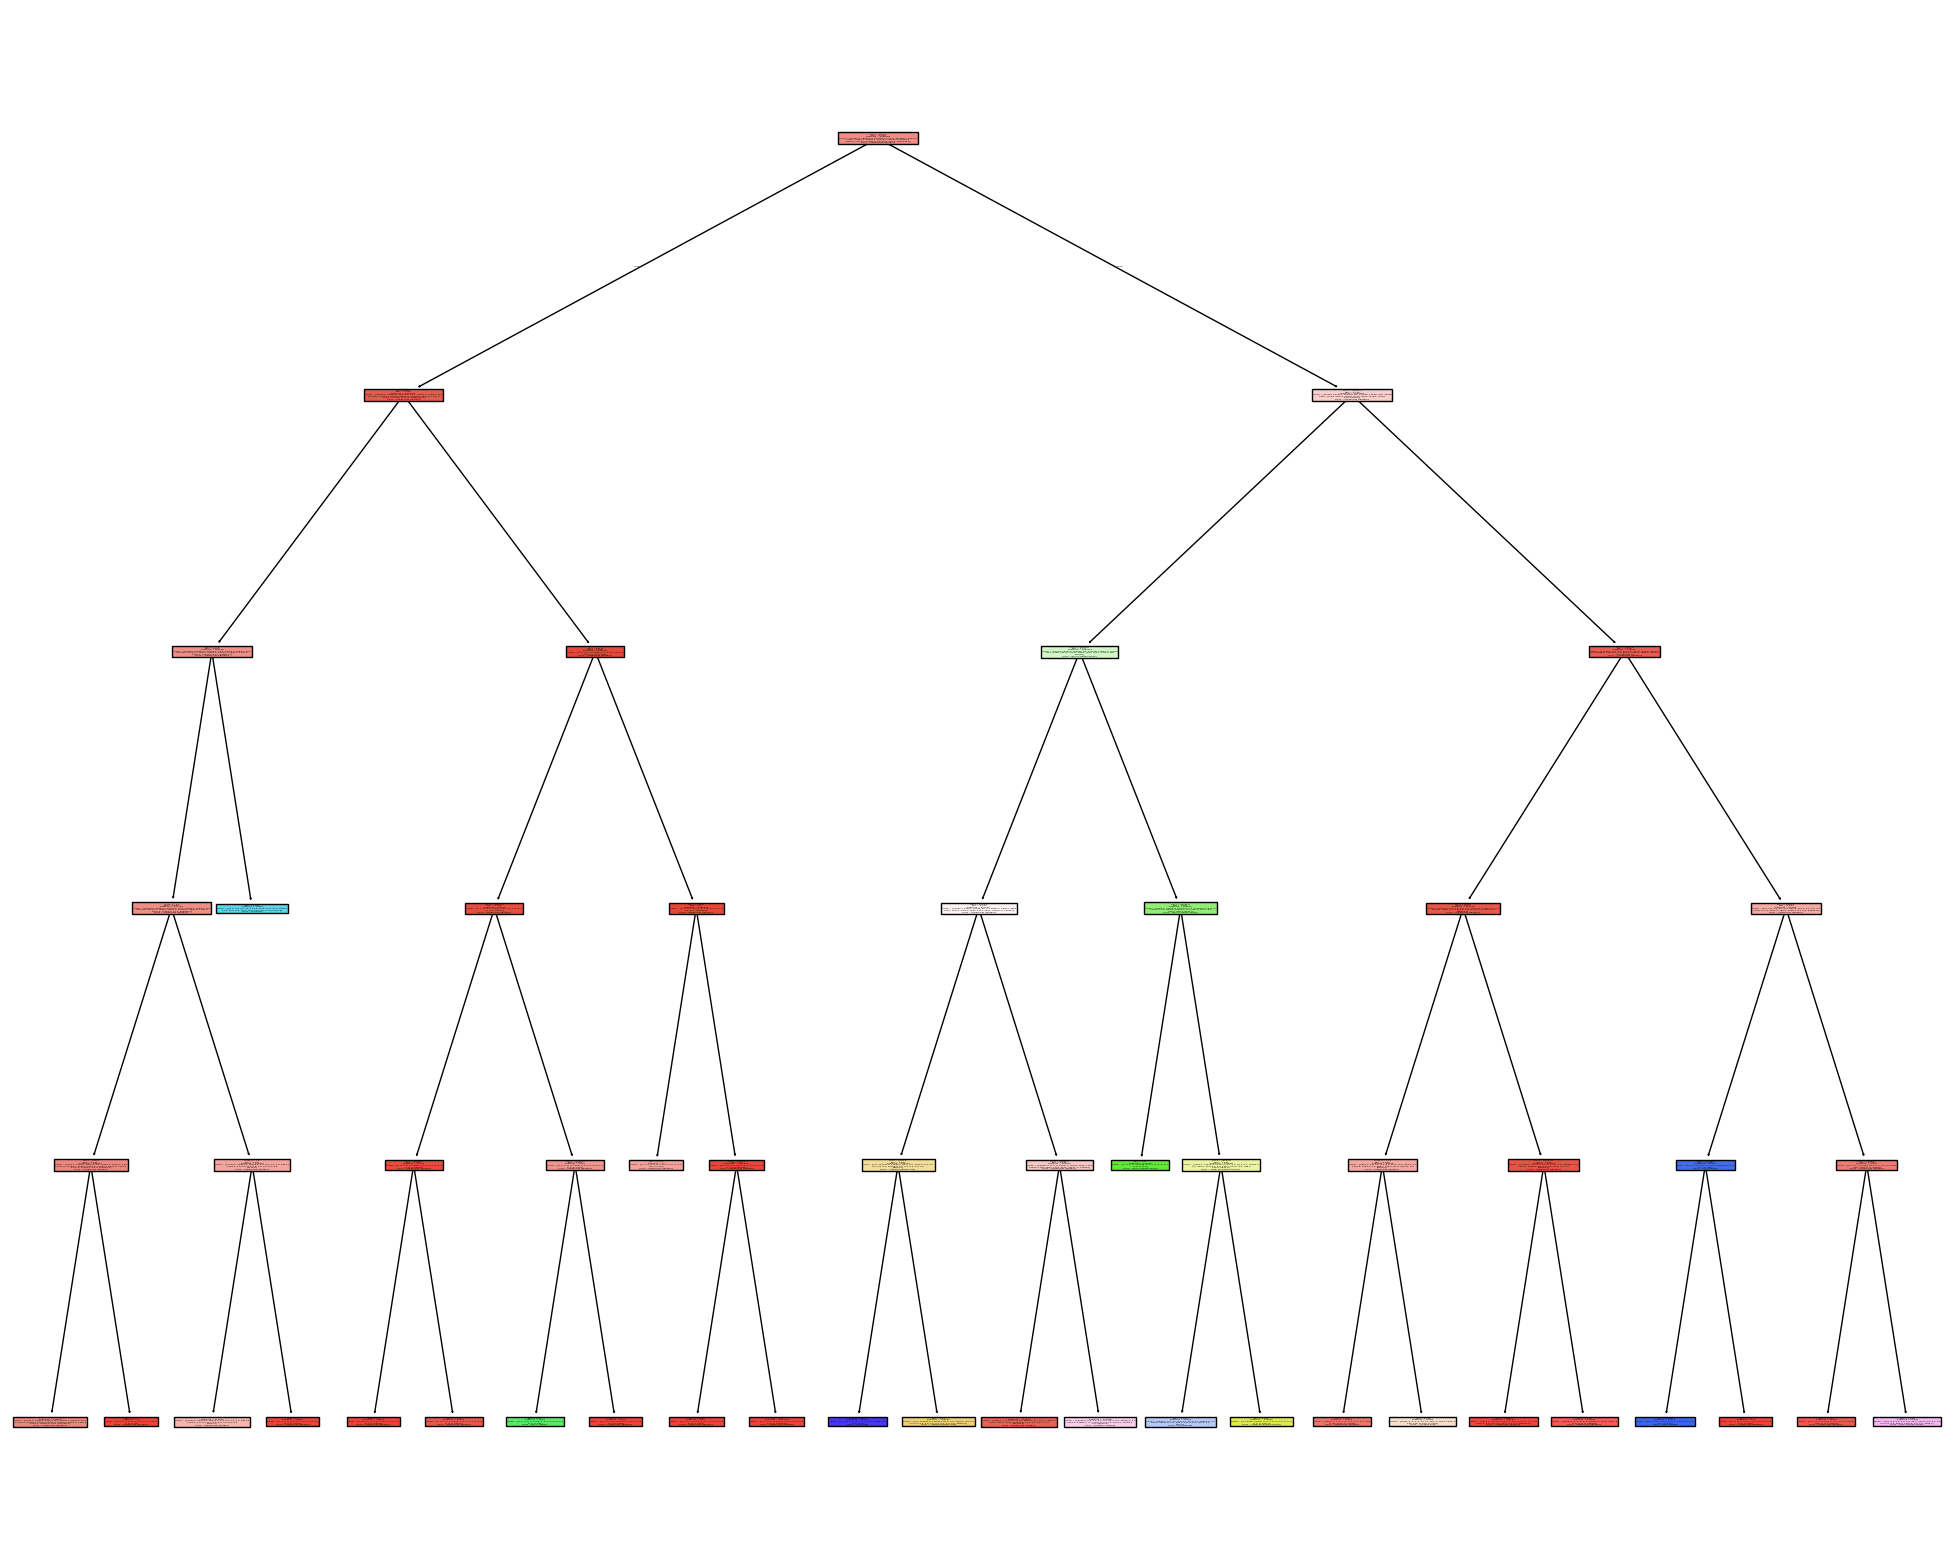

In [ ]:
fig = plt.figure(figsize=(25,20))
_ = plot_tree(dt, feature_names=feature_names, class_names=class_names, filled=True)